## Import Libraries

In [ ]:
!pip install transformers
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
#from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.2 MB/s eta 0:00:00


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# Data Exploration

In [ ]:
import pandas as pd
data=pd.read_csv('agnews_train8.csv')
data.head()

,text,Class Index,conf,MV_world,MV_sports,MV_business,MV_sci
0,Title: Wall St. Bears Claw Back Into the Black...,3,0.905556,0,0,1,0
1,Title: Carlyle Looks Toward Commercial Aerospa...,3,0.922222,0,0,1,0
2,Title: Oil and Economy Cloud Stocks' Outlook (...,3,0.927778,0,0,1,0
3,Title: Iraq Halts Oil Exports from Main Southe...,3,0.911111,0,0,1,0
4,"Title: Oil prices soar to all-time record, pos...",3,0.911111,0,0,1,0


In [ ]:
data2=pd.read_csv('agnews_train2.csv')
data2['conf']=data['conf']

FileNotFoundError: ignored

In [ ]:
def append(text):
  return text+" and give a confidence score for your prediction on a scale of 0 to 1."
data2['prompt1']=data2['prompt1'].apply(append)
data2['prompt2']=data2['prompt2'].apply(append)
data2['prompt3']=data2['prompt3'].apply(append)
data2['prompt4']=data2['prompt4'].apply(append)
data2['prompt5']=data2['prompt5'].apply(append)
data2['prompt6']=data2['prompt6'].apply(append)
data2['prompt7']=data2['prompt7'].apply(append)
data2['prompt8']=data2['prompt8'].apply(append)
data2['prompt9']=data2['prompt9'].apply(append)
data2['prompt10']=data2['prompt10'].apply(append)
data2['prompt11']=data2['prompt11'].apply(append)
data2['prompt12']=data2['prompt12'].apply(append)
data2['prompt13']=data2['prompt13'].apply(append)

In [ ]:
#length calculation for cost computation
df=data2
df['length1']=df['prompt1'].apply(lambda x:len(x.split()))
df['length2']=df['prompt2'].apply(lambda x:len(x.split()))
df['length3']=df['prompt3'].apply(lambda x:len(x.split()))
df['length4']=df['prompt4'].apply(lambda x:len(x.split()))
df['length5']=df['prompt5'].apply(lambda x:len(x.split()))
df['length6']=df['prompt6'].apply(lambda x:len(x.split()))
df['length7']=df['prompt7'].apply(lambda x:len(x.split()))
df['length8']=df['prompt8'].apply(lambda x:len(x.split()))
df['length9']=df['prompt9'].apply(lambda x:len(x.split()))
df['length10']=df['prompt10'].apply(lambda x:len(x.split()))
df['length11']=df['prompt10'].apply(lambda x:len(x.split()))
df['length12']=df['prompt10'].apply(lambda x:len(x.split()))
df['length13']=df['prompt10'].apply(lambda x:len(x.split()))

df['length']=df['length1']+df['length2']+df['length3']+df['length4']+df['length5']+df['length6']+df['length7']+df['length8']+df['length9']+df['length10']+df['length11']+df['length12']+df['length13']

df=df.sort_values(by='conf',ascending=False,ignore_index=True)
# Assuming your dataframe is called 'df'
total_rows = df.shape[0]
num_rows_20_percent = int(total_rows * 1) #can change this to 0.2, 0.4, 0.6, 0.8
print(1154-num_rows_20_percent)
df['allocate'] = 0  # Initialize the new column with 0
df.loc[0:num_rows_20_percent-1, 'allocate'] = 1  # Assign 1 to the first 20% of rows
df2=df[df['allocate']==0]
df1=df[df['allocate']==1]
sum(df1['length'].tolist())

0


1214327

In [ ]:
data_abnormal=data[data['conf']>1]
data_abnormal

,Title: Coming to The Rescue Description:,Class Index,conf,MV_world,MV_sports,MV_business,MV_sci


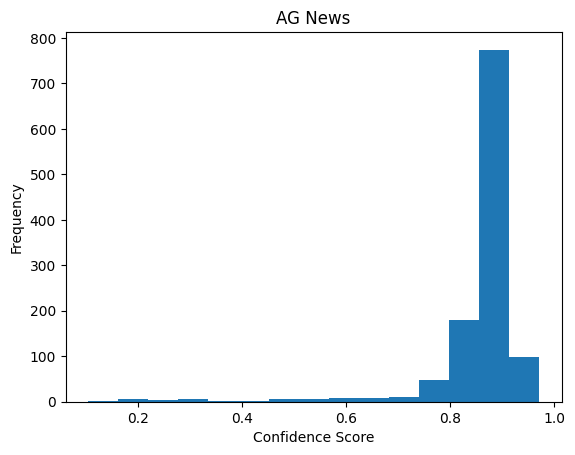

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.hist(data['conf'], bins=15, align='left')

# Add axis labels and a title
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('AG News')
# Display the plot
plt.show()

In [ ]:
#qualitative study of those with high entropy
df_high=data[data['entropy']>0.8]
df_high['text'].tolist()[:10]

['Title: Sprint Set to Debut Video-Streaming Cell Phone Description: OVERLAND PARK, Kan. (AP) -- Channel surfing is moving off the couch as Sprint Corp...',
 'Title: Monday Morning Description: The regular Monday Morning contributors will return to this page next week, as will the weekly poll.',
 'Title: Playing the convergence game Description: Sony and Microsoft confront consumer apathy as they attempt to turn game consoles into multipurpose entertainment gadgets.',
 'Title: Wherenet adds biz rules to RFID Description: The first indication that the value of RFID (radio frequency identification) will extend beyond the supply warehouse was shown last week by WhereNet, a provider of wireless location and communications technology.',
 'Title: AdWatch: Bush Raps Kerry on Intel Reform (AP) Description: AP - Details of new television ad from President Bush to begin airing Monday:',
 "Title: Jackson Squares Off With Attorney Description: SANTA MARIA, Calif. - Dozens of Michael Jackson's fans

In [ ]:
df_low=data[data['entropy']<0.4]
df_low.shape[0]

321

In [ ]:
#length calculation for cost computation
df_low=data[data['entropy']<0.2]
print(df_low.shape[0])
df=df_low
df['length1']=df['prompt1'].apply(lambda x:len(x.split()))
df['length2']=df['prompt2'].apply(lambda x:len(x.split()))
df['length3']=df['prompt3'].apply(lambda x:len(x.split()))
df['length4']=df['prompt4'].apply(lambda x:len(x.split()))
df['length5']=df['prompt5'].apply(lambda x:len(x.split()))
df['length6']=df['prompt6'].apply(lambda x:len(x.split()))
df['length7']=df['prompt7'].apply(lambda x:len(x.split()))
df['length8']=df['prompt8'].apply(lambda x:len(x.split()))
df['length9']=df['prompt9'].apply(lambda x:len(x.split()))
df['length10']=df['prompt10'].apply(lambda x:len(x.split()))
df['length11']=df['prompt11'].apply(lambda x:len(x.split()))
df['length12']=df['prompt12'].apply(lambda x:len(x.split()))
df['length13']=df['prompt13'].apply(lambda x:len(x.split()))
df['length']=df['length1']+df['length2']+df['length3']+df['length4']+df['length5']+df['length6']+df['length7']+df['length8']+df['length9']+df['length10']+df['length11']+df['length12']+df['length13']
#sum(df['length'].tolist())

266


In [ ]:
df_low['text'].tolist()[:5]

["Title: Wall St. Bears Claw Back Into the Black Description:  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.",
 "Title: Rescuing an Old Saver Description: If you think you may need to help your elderly relatives with their finances, don't be shy about having the money talk -- soon.",
 'Title: Veteran inventor in market float Description: Trevor Baylis, the veteran inventor famous for creating the Freeplay clockwork radio, is planning to float his company on the stock market.',
 'Title: Quality Gets Swept Away Description: Quality Distribution is hammered after reporting a large loss for the second quarter.',
 "Title: What's Cool In the Pool ... ... And Hot On the Deck Description: Americans are spending more on tricking out the places where they swim. Here's a look at the new wave of accessories"]

In [ ]:
data_high=data[data['conf']>0.9]
data_high.shape[0]/1154

0.5147313691507799

In [ ]:
data['gold_label']=data['Class Index']
def calculate_alignment(threshold, df_input):
  df_low=df_input[df_input['conf']>=threshold]
  print(df_low.shape[0])
  df_low['world_gold']=df_low['gold_label'].apply(lambda x:1 if x==1 else 0)
  df_low['gold_sports']=df_low['gold_label'].apply(lambda x:1 if x==2 else 0)
  df_low['gold_business']=df_low['gold_label'].apply(lambda x:1 if x==3 else 0)
  df_low['gold_sci']=df_low['gold_label'].apply(lambda x:1 if x==4 else 0)
  df_low_correct1=df_low[df_low['MV_world']==df_low['world_gold']]
  df_low_correct2=df_low[df_low['MV_sports']==df_low['gold_sports']]
  df_low_correct3=df_low[df_low['MV_business']==df_low['gold_business']]
  df_low_correct4=df_low[df_low['MV_sci']==df_low['gold_sci']]
  return (df_low_correct1.shape[0]+df_low_correct2.shape[0]+df_low_correct3.shape[0]+df_low_correct4.shape[0])/4/df_low.shape[0]

In [ ]:
calculate_alignment(0.6, data)

1064


<ipython-input-33-cc88c7172cb6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low['world_gold']=df_low['gold_label'].apply(lambda x:1 if x==1 else 0)
<ipython-input-33-cc88c7172cb6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low['gold_sports']=df_low['gold_label'].apply(lambda x:1 if x==2 else 0)
<ipython-input-33-cc88c7172cb6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

0.9224624060150376

1154
1153
1139
1127
1088
1


<ipython-input-7-d77db73b6074>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low['world_gold']=df_low['gold_label'].apply(lambda x:1 if x==1 else 0)
<ipython-input-7-d77db73b6074>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low['gold_sports']=df_low['gold_label'].apply(lambda x:1 if x==2 else 0)
<ipython-input-7-d77db73b6074>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

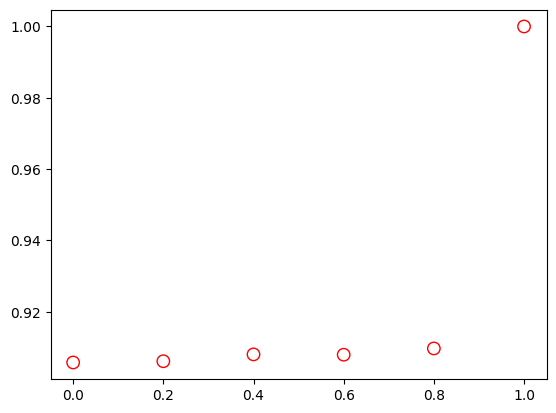

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [0, 0.2, 0.4, 0.6, 0.8, 1]
y = [calculate_alignment(i, data) for i in x]

plt.scatter(x, y, s=80, facecolors='none', edgecolors='r')
plt.show()

In [ ]:
y

[0.9057625649913345,
 0.9061144839549002,
 0.9080333625987709,
 0.907941437444543,
 0.9096966911764706,
 1.0]

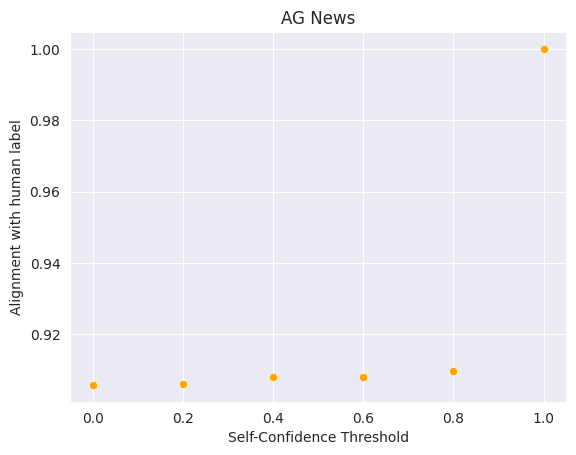

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

x = [0, 0.2, 0.4, 0.6, 0.8, 1]
y = [0.9057625649913345, 0.9061144839549002, 0.9080333625987709, 0.907941437444543, 0.9096966911764706, 1.0]

sns.set_style("darkgrid")  # Set the plot style to 'darkgrid' with gray background
sns.scatterplot(x=x, y=y, color='orange')
plt.xlabel('Self-Confidence Threshold')
plt.ylabel('Alignment with human label')
plt.title('AG News')
plt.show()

1088
1070
1029
990
895
724
304
100
40


<ipython-input-26-d77db73b6074>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low['world_gold']=df_low['gold_label'].apply(lambda x:1 if x==1 else 0)
<ipython-input-26-d77db73b6074>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low['gold_sports']=df_low['gold_label'].apply(lambda x:1 if x==2 else 0)
<ipython-input-26-d77db73b6074>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

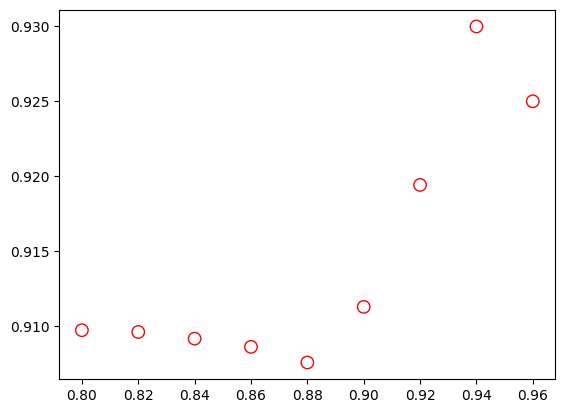

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96]
y = [calculate_alignment(i, data) for i in x]

plt.scatter(x, y, s=80, facecolors='none', edgecolors='r')
plt.show()

In [ ]:
import pandas as pd
df=data
df=df.sort_values(by='conf',ascending=False,ignore_index=True)
# Assuming your dataframe is called 'df'
total_rows = df.shape[0]
num_rows_20_percent = int(total_rows * 1) #can change this to 0.2, 0.4, 0.6, 0.8


df['allocate'] = 0  # Initialize the new column with 0
df.loc[:num_rows_20_percent-1, 'allocate'] = 1  # Assign 1 to the first 20% of rows

df.head()

,text,Class Index,conf,MV_world,MV_sports,MV_business,MV_sci,allocate
0,Title: Cassini finds new Saturn moons Descript...,4,1.000000,0,0,0,1,1
1,Title: Thorpe Wins Men's 200 Freestyle Descrip...,2,0.994444,0,1,0,0,1
2,Title: What are the best cities for business i...,3,0.994444,0,0,1,0,1
3,Title: Editor's Picks: The Best of our Web Ser...,4,0.994444,0,0,0,1,1
4,Title: Google seeks to end auction Tuesday Des...,4,0.988889,0,0,1,0,1


In [ ]:
#combined
df['gold_label']=df['Class Index']
world=[]
sports=[]
business=[]
sci=[]
chatgpt_count=0
for index, row in df.iterrows():
    if row['allocate']==1:
      world.append(row['MV_world'])
      sports.append(row['MV_sports'])
      business.append(row['MV_business'])
      sci.append(row['MV_sci'])
    else:
      if row['gold_label']==1:
        world.append(1)
        sports.append(0)
        business.append(0)
        sci.append(0)
      elif row['gold_label']==2:
        world.append(0)
        sports.append(1)
        business.append(0)
        sci.append(0)
      elif row['gold_label']==3:
        world.append(0)
        sports.append(0)
        business.append(1)
        sci.append(0)
      elif row['gold_label']==4:
        world.append(0)
        sports.append(0)
        business.append(0)
        sci.append(1)
df['world']=world
df['sports']=sports
df['business']=business
df['sci']=sci
df.head()

,text,Class Index,conf,MV_world,MV_sports,MV_business,MV_sci,allocate,gold_label,world,sports,business,sci
0,Title: Cassini finds new Saturn moons Descript...,4,1.000000,0,0,0,1,1,4,0,0,0,1
1,Title: Thorpe Wins Men's 200 Freestyle Descrip...,2,0.994444,0,1,0,0,1,2,0,1,0,0
2,Title: What are the best cities for business i...,3,0.994444,0,0,1,0,1,3,0,0,1,0
3,Title: Editor's Picks: The Best of our Web Ser...,4,0.994444,0,0,0,1,1,4,0,0,0,1
4,Title: Google seeks to end auction Tuesday Des...,4,0.988889,0,0,1,0,1,4,0,0,1,0


In [ ]:
df=df.drop(91)

In [ ]:
df=df.drop(484)

In [ ]:
df=df.drop(1116)

# Fine-tuning



Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [ ]:
#df = data #jigsaw-toxic-comment-classification-challenge

In [ ]:
#combined
cols = df.columns
label_cols = list(cols[9:13])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['world', 'sports', 'business', 'sci']


In [ ]:
print('Count of 1 per label: \n', df[label_cols].sum(), '\n') # Label counts, may need to downsample or upsample
print('Count of 0 per label: \n', df[label_cols].eq(0).sum())

Count of 1 per label: 
 world       270
sports      272
business    418
sci         202
dtype: int64 

Count of 0 per label: 
 world       881
sports      879
business    733
sci         949
dtype: int64


In [ ]:
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,text,Class Index,conf,MV_world,MV_sports,MV_business,MV_sci,allocate,gold_label,world,sports,business,sci,one_hot_labels
0,Title: Cassini finds new Saturn moons Descript...,4,1.000000,0,0,0,1,1,4,0,0,0,1,"[0, 0, 0, 1]"
1,Title: Thorpe Wins Men's 200 Freestyle Descrip...,2,0.994444,0,1,0,0,1,2,0,1,0,0,"[0, 1, 0, 0]"
2,Title: What are the best cities for business i...,3,0.994444,0,0,1,0,1,3,0,0,1,0,"[0, 0, 1, 0]"
3,Title: Editor's Picks: The Best of our Web Ser...,4,0.994444,0,0,0,1,1,4,0,0,0,1,"[0, 0, 0, 1]"
4,Title: Google seeks to end auction Tuesday Des...,4,0.988889,0,0,1,0,1,4,0,0,1,0,"[0, 0, 1, 0]"


In [ ]:
labels = list(df.one_hot_labels.values)
comments = list(df.text.values)

Load the pretrained tokenizer that corresponds to your choice in model. e.g.,

```
BERT:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

XLNet:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)

RoBERTa:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
```


In order to avoid memory issues with Google Colab, I enforce a max_length of 100 tokens. Note that some sentences may not adequately represent each label because of this.

In [ ]:
from transformers import RobertaTokenizer
max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(comments,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [ ]:
encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
#token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [ ]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  []


In [ ]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
#one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

Be sure to handle all classes during validation using "stratify" during train/validation split:

In [ ]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=20, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
#train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
#train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
#validation_token_types = torch.tensor(validation_token_types)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

## Load Model & Set Params

Load the appropriate model below, each model already contains a single dense layer for classification on top.



```
BERT:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

XLNet:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)

RoBERTa:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
```



In [ ]:
# Load model, the pretrained model will include a single linear classification layer on top for classification.
from transformers import RobertaForSequenceClassification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should pr

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Setting custom optimization parameters for the AdamW optimizer https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [ ]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
from transformers import AdamW
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5 ,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train Model

In [ ]:
def is_max(array):
  max_val=max(array)
  res=[i==max_val for i in array]
  return res

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss()
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss()
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  #threshold = 0.30
  #pred_bools = [pl>threshold for pl in pred_labels]
  #print(pred_labels)
  #max_val = max(pred_labels)
  pred_bools = [is_max(arr) for arr in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


OutOfMemoryError: ignored

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss()
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss()
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  #threshold = 0.30
  #pred_bools = [pl>threshold for pl in pred_labels]
  #print(pred_labels)
  #max_val = max(pred_labels)
  pred_bools = [is_max(arr) for arr in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.025419917917595458


Epoch:  20%|██        | 1/5 [00:18<01:14, 18.53s/it]

F1 Validation Accuracy:  82.75862068965517
Flat Validation Accuracy:  82.75862068965517
Train loss: 0.021188997162076142


Epoch:  40%|████      | 2/5 [00:37<00:56, 18.79s/it]

F1 Validation Accuracy:  81.03448275862068
Flat Validation Accuracy:  81.03448275862068
Train loss: 0.021381761334263363


Epoch:  60%|██████    | 3/5 [00:56<00:37, 18.79s/it]

F1 Validation Accuracy:  81.89655172413794
Flat Validation Accuracy:  81.89655172413794
Train loss: 0.02045951306533355


Epoch:  80%|████████  | 4/5 [01:14<00:18, 18.67s/it]

F1 Validation Accuracy:  83.62068965517241
Flat Validation Accuracy:  83.62068965517241
Train loss: 0.01706601111218333


Epoch: 100%|██████████| 5/5 [01:33<00:00, 18.65s/it]

F1 Validation Accuracy:  81.89655172413794
Flat Validation Accuracy:  81.89655172413794


# Evaluation

## Load and Preprocess Test Data

In [ ]:
test_df = pd.read_csv('agnews_test.csv')
#test_labels_df = pd.read_csv('test_labels.csv')
#test_df = test_df.merge(test_labels_df, on='id', how='left')
# test_df['text']=test_df['sentence']
test_df['world']=test_df['gold_label'].apply(lambda x:1 if x==1 else 0)
test_df['sports']=test_df['gold_label'].apply(lambda x:1 if x==2 else 0)
test_df['business']=test_df['gold_label'].apply(lambda x:1 if x==3 else 0)
test_df['sci']=test_df['gold_label'].apply(lambda x:1 if x==4 else 0)
#print('Null values: ', test_df.isnull().values.any()) #should not be any null sentences or labels
#print('Same columns between train and test: ', label_cols == test_label_cols) #columns should be the same
test_df.tail()

,Class Index,Title,Description,text,gold_label,world,sports,business,sci
495,2,Pressure points,ATHENS -- The booing went on for nearly 10 min...,Title: Pressure points Description: ATHENS -- ...,2,0,1,0,0
496,3,Unions protest as overtime rules take effect,WASHINGTON -- Hundreds of workers rallied on t...,Title: Unions protest as overtime rules take e...,3,0,0,1,0
497,1,Serb denies siege terror charges,A Bosnian Serb general accused of organising t...,Title: Serb denies siege terror charges Descri...,1,1,0,0,0
498,2,11th-hour highlights too late,NBC's prime-time Olympic coverage is taped and...,Title: 11th-hour highlights too late Descripti...,2,0,1,0,0
499,4,No IE? No Can See,One thing that #39;s always irritated those wh...,Title: No IE? No Can See Description: One thin...,4,0,0,0,1


In [ ]:
test_label_cols = list(test_df.columns[5:])
test_label_cols

['world', 'sports', 'business', 'sci']

In [ ]:
test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)] #remove irrelevant rows/comments with -1 values
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

,Class Index,Title,Description,text,gold_label,world,sports,business,sci,one_hot_labels
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,Title: Fears for T N pension after talks Descr...,3,0,0,1,0,"[0, 0, 1, 0]"
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",Title: The Race is On: Second Private Team Set...,4,0,0,0,1,"[0, 0, 0, 1]"
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,Title: Ky. Company Wins Grant to Study Peptide...,4,0,0,0,1,"[0, 0, 0, 1]"
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,Title: Prediction Unit Helps Forecast Wildfire...,4,0,0,0,1,"[0, 0, 0, 1]"
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,Title: Calif. Aims to Limit Farm-Related Smog ...,4,0,0,0,1,"[0, 0, 0, 1]"


In [ ]:
# Gathering input data
test_labels = list(test_df.one_hot_labels.values)
test_comments = list(test_df.text.values)

In [ ]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
#test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
#test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
#test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

## Prediction and Metics

In [ ]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  #b_input_ids, b_input_mask = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

We need to threshold our sigmoid function outputs which range from [0, 1]. Below I use 0.50 as a threshold.

In [ ]:
#all human
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Test F1 Accuracy:  0.88
Test Flat Accuracy:  0.88 

              precision    recall  f1-score   support

       world       0.85      0.92      0.88       122
      sports       0.96      0.94      0.95       145
    business       0.81      0.76      0.79       106
         sci       0.88      0.87      0.87       127

   micro avg       0.88      0.88      0.88       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.88      0.88      0.88       500
 samples avg       0.88      0.88      0.88       500



In [ ]:
#combined - 0.2
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Macro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Micro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Weighted Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Macro Test F1 Accuracy:  0.860164065271578
Micro Test F1 Accuracy:  0.868
Weighted Test F1 Accuracy:  0.867295200762876
Test Flat Accuracy:  0.868 

              precision    recall  f1-score   support

       world       0.86      0.89      0.87       122
      sports       0.95      0.98      0.96       145
    business       0.77      0.78      0.78       106
         sci       0.87      0.80      0.83       127

   micro avg       0.87      0.87      0.87       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.87      0.87      0.87       500
 samples avg       0.87      0.87      0.87       500



In [ ]:
#combined - 0.4
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Macro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Micro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Weighted Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Macro Test F1 Accuracy:  0.8489270374996141
Micro Test F1 Accuracy:  0.8599999999999999
Weighted Test F1 Accuracy:  0.8574014009534355
Test Flat Accuracy:  0.86 

              precision    recall  f1-score   support

       world       0.87      0.88      0.87       122
      sports       0.95      0.94      0.95       145
    business       0.82      0.65      0.73       106
         sci       0.79      0.92      0.85       127

   micro avg       0.86      0.86      0.86       500
   macro avg       0.86      0.85      0.85       500
weighted avg       0.86      0.86      0.86       500
 samples avg       0.86      0.86      0.86       500



In [ ]:
#combined - 0.6
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Macro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Micro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Weighted Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Macro Test F1 Accuracy:  0.8409243667370322
Micro Test F1 Accuracy:  0.848
Weighted Test F1 Accuracy:  0.8488411074868725
Test Flat Accuracy:  0.848 

              precision    recall  f1-score   support

       world       0.91      0.85      0.88       122
      sports       0.95      0.98      0.97       145
    business       0.64      0.91      0.75       106
         sci       0.94      0.65      0.77       127

   micro avg       0.85      0.85      0.85       500
   macro avg       0.86      0.85      0.84       500
weighted avg       0.87      0.85      0.85       500
 samples avg       0.85      0.85      0.85       500



In [ ]:
#combined - 0.8
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Macro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Micro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Weighted Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Macro Test F1 Accuracy:  0.8214350559112206
Micro Test F1 Accuracy:  0.83
Weighted Test F1 Accuracy:  0.8300533363440571
Test Flat Accuracy:  0.83 

              precision    recall  f1-score   support

       world       0.89      0.84      0.86       122
      sports       0.95      0.98      0.96       145
    business       0.61      0.90      0.73       106
         sci       0.95      0.60      0.73       127

   micro avg       0.83      0.83      0.83       500
   macro avg       0.85      0.83      0.82       500
weighted avg       0.86      0.83      0.83       500
 samples avg       0.83      0.83      0.83       500



In [ ]:
#combined - 1
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Macro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Micro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Weighted Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Macro Test F1 Accuracy:  0.8214350559112206
Micro Test F1 Accuracy:  0.83
Weighted Test F1 Accuracy:  0.8300533363440571
Test Flat Accuracy:  0.83 

              precision    recall  f1-score   support

       world       0.89      0.84      0.86       122
      sports       0.95      0.98      0.96       145
    business       0.61      0.90      0.73       106
         sci       0.95      0.60      0.73       127

   micro avg       0.83      0.83      0.83       500
   macro avg       0.85      0.83      0.82       500
weighted avg       0.86      0.83      0.83       500
 samples avg       0.83      0.83      0.83       500

